# Econometric Analysis of Suicide Data
In this notebook, the *Suicide Rates 1985-2005* dataset from Kaggle is explored. This is a union of four different datasets, taken from sources such as the World Bank and World Health Organisation. Our goal will be to understand what factors most strongly influence suicide rates and how these may have changed over time. In particular, we will seek to answer three questions:
1. Overall, how do suicide rates vary by gender, age and generation?
2. Has the suicide rate changed over time?
3. How does per capita GDP correlate with suicide rates? Do these effects vary by gender or age?

In [1]:
library(tidyverse)
library(ggfortify)

blog_colour <- "#fdfdfd"
theme_set(theme_classic() + 
            theme(plot.background = element_rect(fill = blog_colour),
                  panel.background = element_rect(fill = blog_colour),
                  legend.background = element_rect(fill = blog_colour)))

options(warn=-1)

suicide_data <- read_csv('master.csv') %>%
    mutate(age=factor(age, levels=c('5-14 years', '15-24 years', '25-34 years', 
                                    '35-54 years', '55-74 years', '75+ years')),
           generation=factor(generation, levels=c('G.I. Generation', 'Silent', 'Boomers',
                                                  'Generation X', 'Millenials')))

Warning message:
“package ‘tidyverse’ was built under R version 3.4.2”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘tibble’ was built under R version 3.4.3”Warning message:
“package ‘tidyr’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.2”Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘stringr’ was built under R version 3.4.3”Warning message:
“package ‘forcats’ was built under R version 3.4.3”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘ggfortify’ was built under R version 3.4.4”Parsed w

## Evaluating the Data
The *Suicide Rates 1985-2005* dataset is composed of a set of basic demographic variables (year, country, age group and generation, sex, total population size), as well two economic indicators (GDP and HDI). Our goal will be to use these variables to model the suicide rate across different cohorts.

In [2]:
glimpse(suicide_data)

Observations: 27,820
Variables: 12
$ country              <chr> "Albania", "Albania", "Albania", "Albania", "A...
$ year                 <int> 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1987...
$ sex                  <chr> "male", "male", "female", "male", "male", "fem...
$ age                  <fct> 15-24 years, 35-54 years, 15-24 years, 75+ yea...
$ suicides_no          <int> 21, 16, 14, 1, 9, 1, 6, 4, 1, 0, 0, 0, 2, 17, ...
$ population           <int> 312900, 308000, 289700, 21800, 274300, 35600, ...
$ `suicides/100k pop`  <dbl> 6.71, 5.19, 4.83, 4.59, 3.28, 2.81, 2.15, 1.56...
$ `country-year`       <chr> "Albania1987", "Albania1987", "Albania1987", "...
$ `HDI for year`       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA...
$ `gdp_for_year ($)`   <dbl> 2156624900, 2156624900, 2156624900, 2156624900...
$ `gdp_per_capita ($)` <int> 796, 796, 796, 796, 796, 796, 796, 796, 796, 7...
$ generation           <fct> Generation X, Silent, Generation X, G.I. Gener...


In order to maximise the integrity of our analyses, it is important to first ensure that we have a high-quality dataset. This is a vague requirement, but it is easy to envision some simple checks that will provide us confidence over the accuracy and completeness of the data:
- Do all countries have a similar date range and number of records? Or is data only available for certain time spans?
- Do all countries contain the entire set of age groups across their date range? Or are some age groups missing from certain countries?
- Are there any explicitly missing values for any of the variables? Why might these be missing, and is this significant? 
- Are there any obviously incorrect numeric values? Can we safely omit these?

Let's start by looking at the number of countries available per year. This will ensure that when we make claims such as "the global average suicide rate increased in 1995" that we are indeed speaking of a representative sample of countries.

Saving 7 x 7 in image


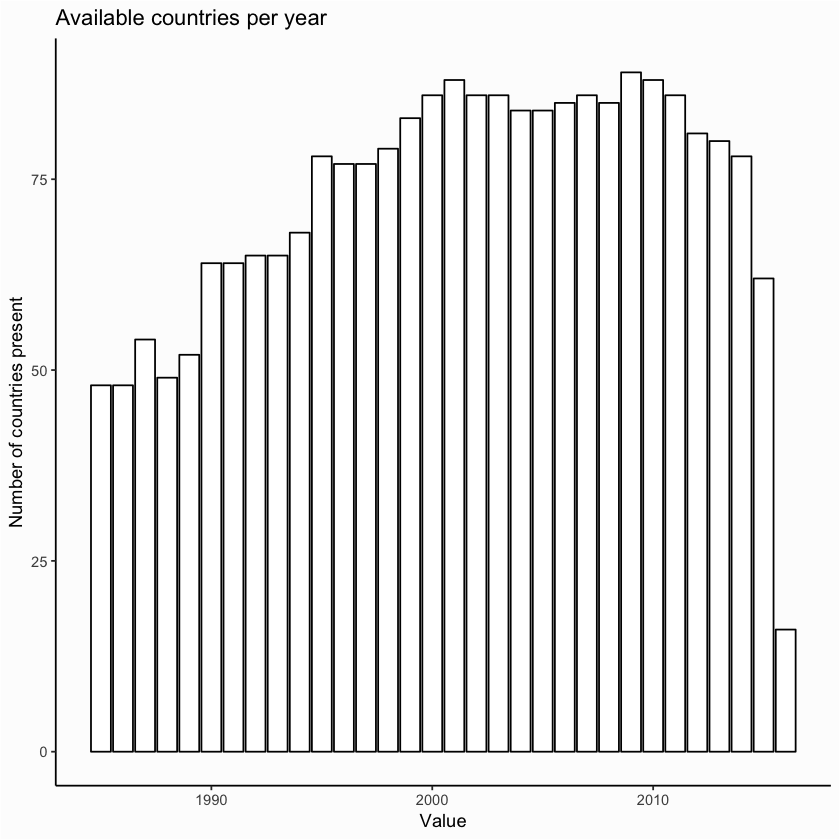

In [3]:
suicide_data %>%
    group_by(year) %>%
    summarise(n_countries=n_distinct(country)) %>%
    ggplot(aes(x=year, y=n_countries)) +
        geom_col(color='black', fill='white') +
        xlab('Value') + ylab('Number of countries present') +
        ggtitle('Available countries per year')

ggsave('visuals/data_density.png')

The density of data appears to be highest between 1990 and 2014, with data for several countries missing outside this period. For this reason, we will drop the data outside this range, as it will not allow a reasonable comparison across countries.

In [4]:
suicide_data <- suicide_data %>%
    filter(year >= 1990 & year <= 2014)

Now let's check whether, for each year, each country has data for each age group and gender. If this were not the case, we could be accidentally making inferences about entire populations that might only apply to certain segments of the population. Since there are six distinct age groups and two sexes, we expect $6 \times 2 = 12$ rows of data for each country, for each year.

In [5]:
suicide_data %>%
    group_by(year, country) %>%
    summarise(n_rows=n()) %>%
    filter(n_rows!=12) %>%
    nrow()

[1] 0

Fortunately it appears that we do indeed have data for every subgroup. However, we are not particularly interested in the suicide rates of 5-14 year olds, as they will likely be very low and exhibit high variance. Let's omit this group.

In [6]:
suicide_data <- suicide_data %>%
    filter(age != '5-14 years')


Next we check for any explicitly missing values, typically denoted with an NA or NaN value. These differ from implicitly missing values, which are not present at all in the dataset. 

In [7]:
suicide_data %>%
    map_dbl(~ mean(is.na(.)))

country               year                sex                age 
         0.0000000          0.0000000          0.0000000          0.0000000 
       suicides_no         population  suicides/100k pop       country-year 
         0.0000000          0.0000000          0.0000000          0.0000000 
      HDI for year   gdp_for_year ($) gdp_per_capita ($)         generation 
         0.6686747          0.0000000          0.0000000          0.0000000

It appears that a large fraction of records (67%) are missing values for the HDI variable. Why might this be? If we investigate further which specific years are missing data, we find that for most of the remaining sample, the HDI is only computed every five years. Only since 2010 is the variable available every year.

Saving 7 x 7 in image


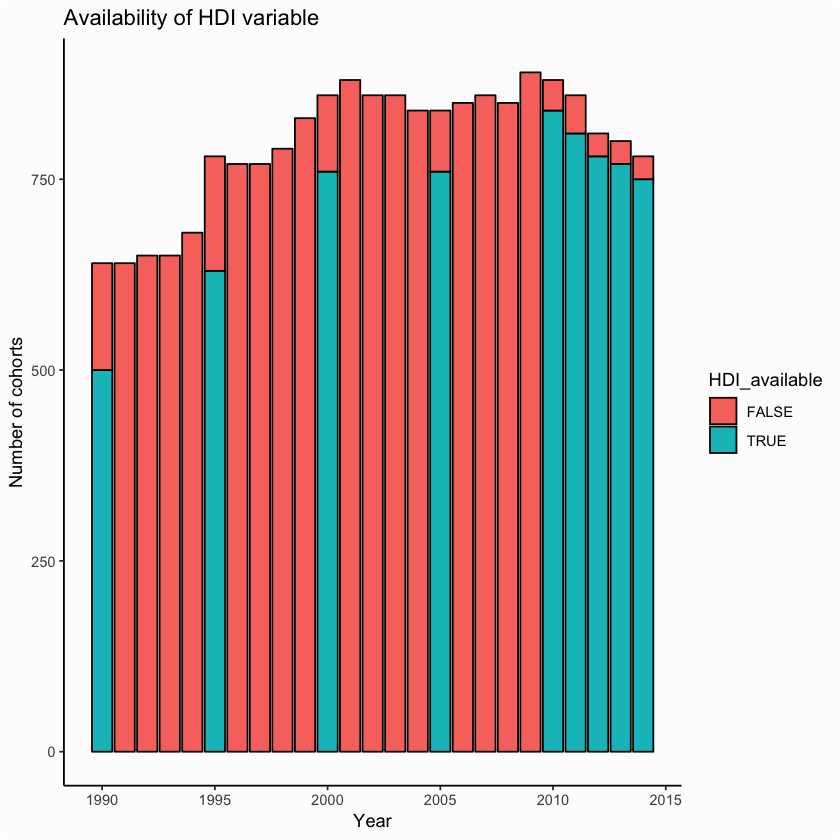

In [8]:
suicide_data %>%
    mutate(HDI_available=!is.na(`HDI for year`)) %>%
    ggplot(aes(x=year, fill=HDI_available)) +
        geom_bar(color='black') +
        xlab('Year') + ylab('Number of cohorts') +
        ggtitle('Availability of HDI variable')

ggsave('visuals/HDI_availability.png')

This is not necessarily a reason to drop the variable, but is certainly worth taking into account if we decide to use it in a model.

Lets check for any strange numeric values.

Saving 7 x 7 in image


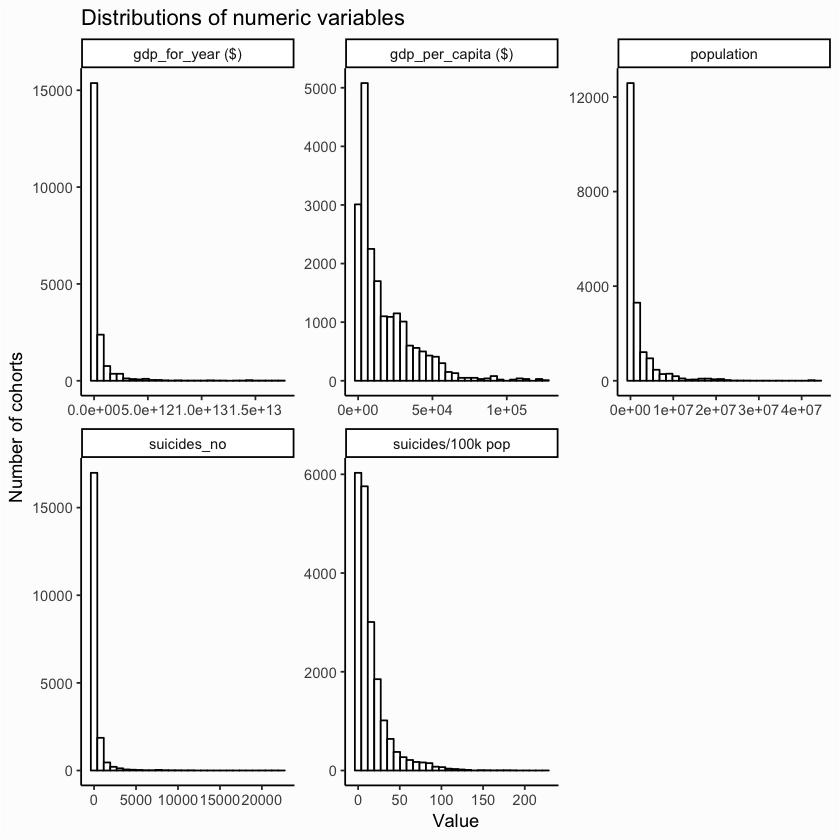

In [9]:
suicide_data %>%
    select(suicides_no, population, `suicides/100k pop`, `gdp_for_year ($)`, `gdp_per_capita ($)`) %>%
    gather() %>%
    ggplot(aes(value)) +
        geom_histogram(bins=30, color='black', fill='white') +
        facet_wrap(key ~ ., scales='free') +
        xlab('Value') + ylab('Number of cohorts') +
        ggtitle('Distributions of numeric variables')

ggsave('visuals/numeric_variabels.png')

A cursory examination of these distributions would suggest nothing untoward: all are strongly right-skewed, as we would expect, with values mostly concentrated around the lower end of the distribution. None exhibit any oddities or obvious outliers. For this reason, we do not need to drop any further records.

Last, an arbitrary choice: focussing on only large countries. This will reduce our overall sample size, but it will mean we have greater comparability across our sample. In particular, we drop all countries which have had a population below five million between 1990-2014.

In [10]:
large_countries <- suicide_data %>%
    group_by(country, year) %>%
    summarise(population = sum(population)) %>%
    group_by(country) %>%
    summarise(min_population = min(population)) %>%
    filter(min_population >= 5000000) %>%
    pull(country)

suicide_data <- suicide_data %>%
    filter(country %in% large_countries)

## Exploratory Analysis
We begin by generating a simple histogram of suicide rates to understand how the value is distributed.

Saving 7 x 7 in image


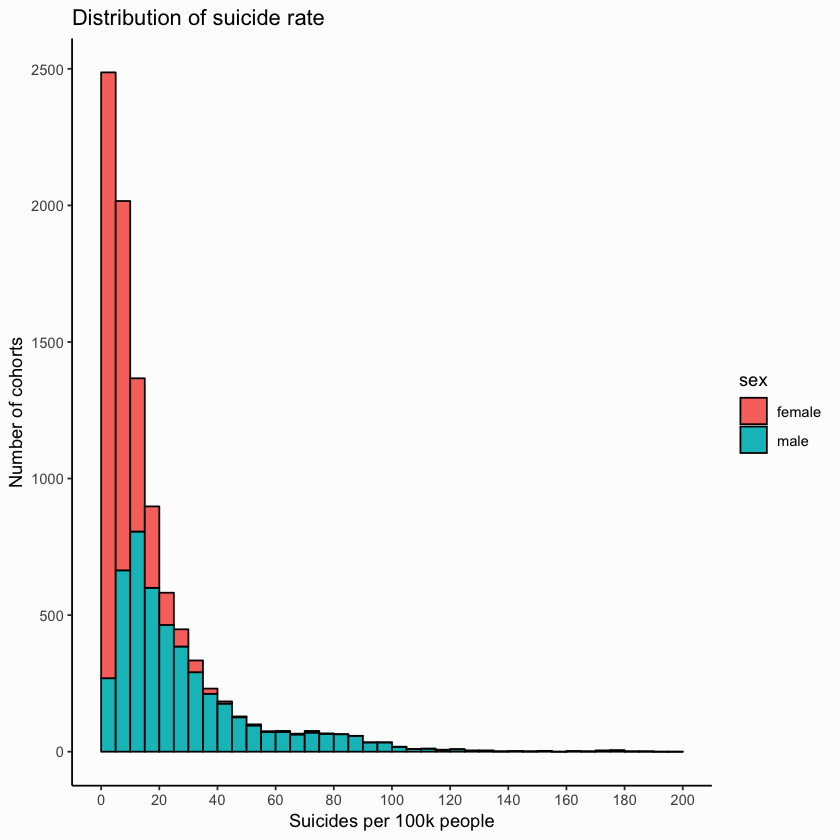

In [11]:
suicide_data %>%
    ggplot(aes(`suicides/100k pop`, fill=sex)) +
        geom_histogram(color='black', breaks=seq(0,200,5)) +
        scale_x_continuous(breaks=seq(0,200,20)) +
        xlab('Suicides per 100k people') + ylab('Number of cohorts') +
        ggtitle('Distribution of suicide rate')

ggsave('visuals/suicide_rate_hist.png')

As would be expected, the variable is strongly right-skewed. Most cohorts have very low suicide rates, while a few have very high rates. In particular, the vast majority of low suicide rates are observed in female cohorts. This distribution is robust across all age groups...

Saving 7 x 7 in image


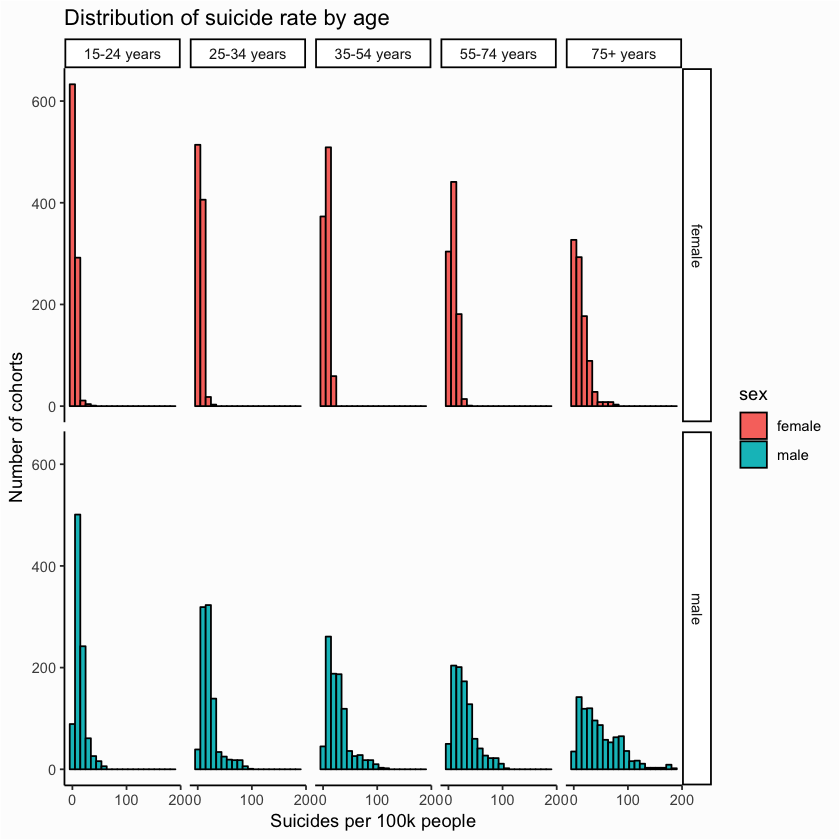

In [12]:
suicide_data %>%
    ggplot(aes(`suicides/100k pop`, fill=sex)) +
        geom_histogram(color='black', bins=20) +
        facet_grid(sex ~ age) +
        scale_x_continuous(breaks=seq(0,200,100)) +
        xlab('Suicides per 100k people') + ylab('Number of cohorts') +
        ggtitle('Distribution of suicide rate by age')

ggsave('visuals/suicide_rate_hist_ages.png')

...across generations...

Saving 7 x 7 in image


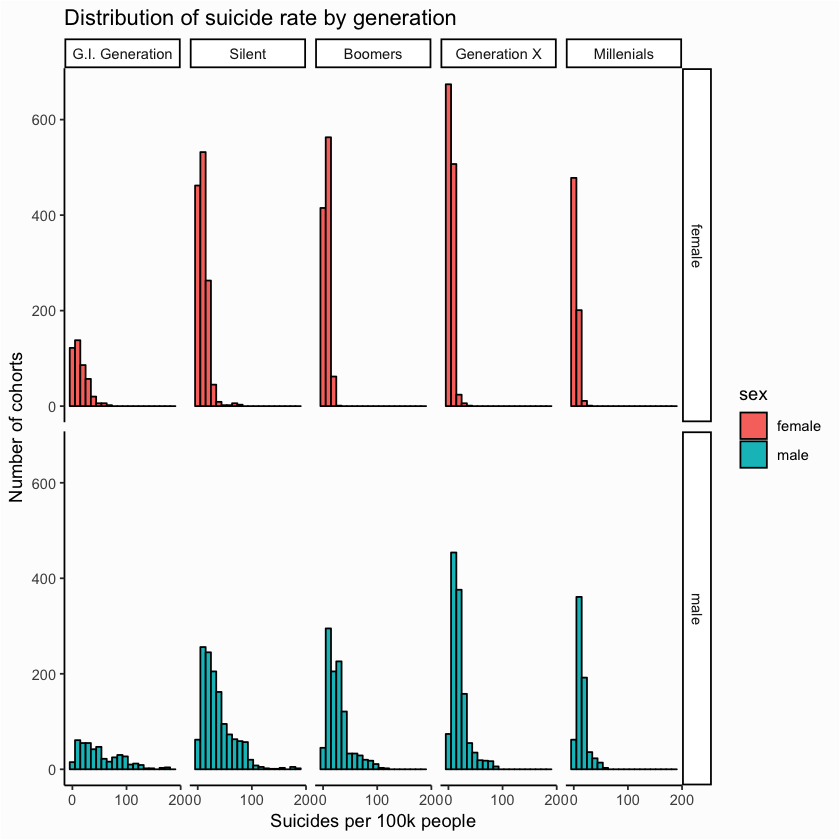

In [13]:
suicide_data %>%
    ggplot(aes(`suicides/100k pop`, fill=sex)) +
        geom_histogram(color='black', bins=20) +
        facet_grid(sex ~ generation) +
        scale_x_continuous(breaks=seq(0,200,100)) +
        xlab('Suicides per 100k people') + ylab('Number of cohorts') +
        ggtitle('Distribution of suicide rate by generation')

ggsave('visuals/suicide_rate_hist_gens.png')

...and across countries.

Saving 7 x 7 in image


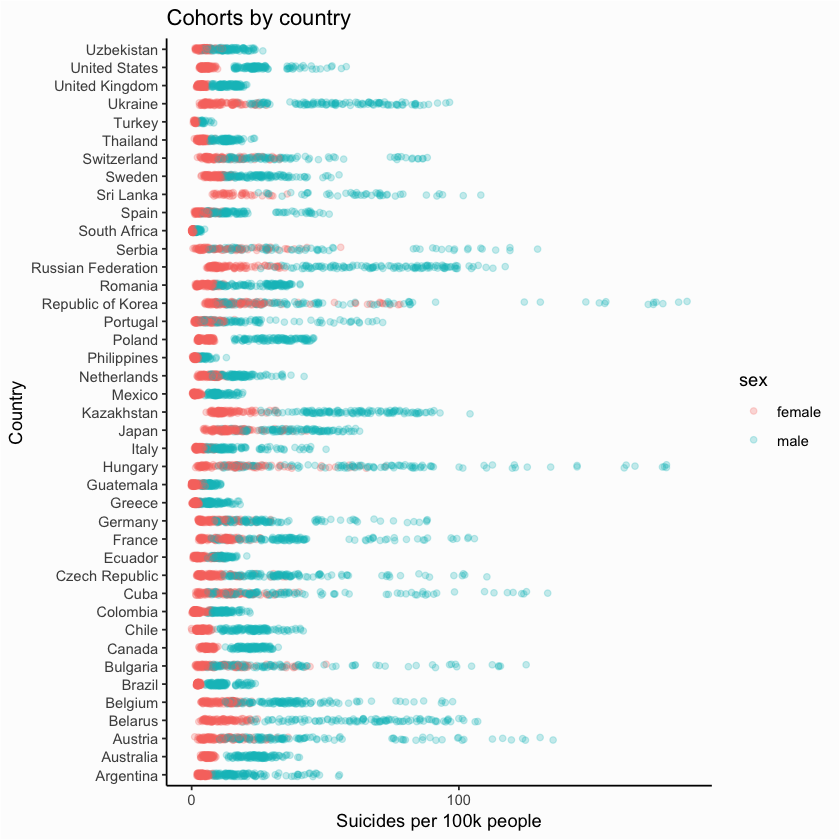

In [14]:
suicide_data %>%
    ggplot(aes(y=country, x=`suicides/100k pop`, color=sex)) +
        geom_jitter(alpha=0.25, width=0.1, height=0.1) +
        scale_x_continuous(breaks=seq(0,200,100)) +
        xlab('Suicides per 100k people') + ylab('Country') +
        ggtitle('Cohorts by country')

ggsave('visuals/suicide_rate_countries.png')

Next lets consider how the suicide rate has changed in my home country, Australia, compared with the average across other large countries.

Saving 7 x 7 in image


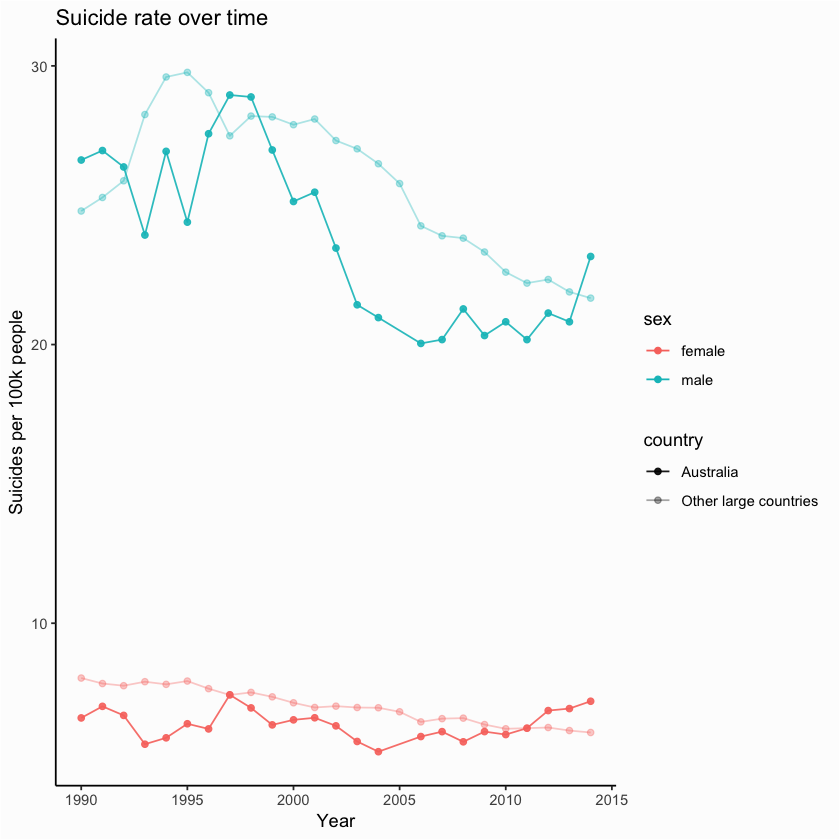

In [15]:
suicide_data_australia <- suicide_data %>%
    filter(country=='Australia') %>%
    group_by(year, sex) %>%
    summarise(suicide_rate=100000*sum(suicides_no)/sum(population), country='Australia')

suicide_data_global <- suicide_data %>%
    group_by(year, sex) %>%
    summarise(suicide_rate=100000*sum(suicides_no)/sum(population), country='Other large countries')

bind_rows(suicide_data_australia, suicide_data_global) %>%
    ggplot(aes(x=year, y=suicide_rate, color=sex, alpha=country)) +
        geom_line() +
        geom_point() +
        scale_alpha_discrete(range = c(0.9, 0.35)) +
        xlab('Year') + ylab('Suicides per 100k people') +
        ggtitle('Suicide rate over time')

ggsave('visuals/rate_over_time.png')

What about changes in specific cohorts?

Saving 7 x 7 in image


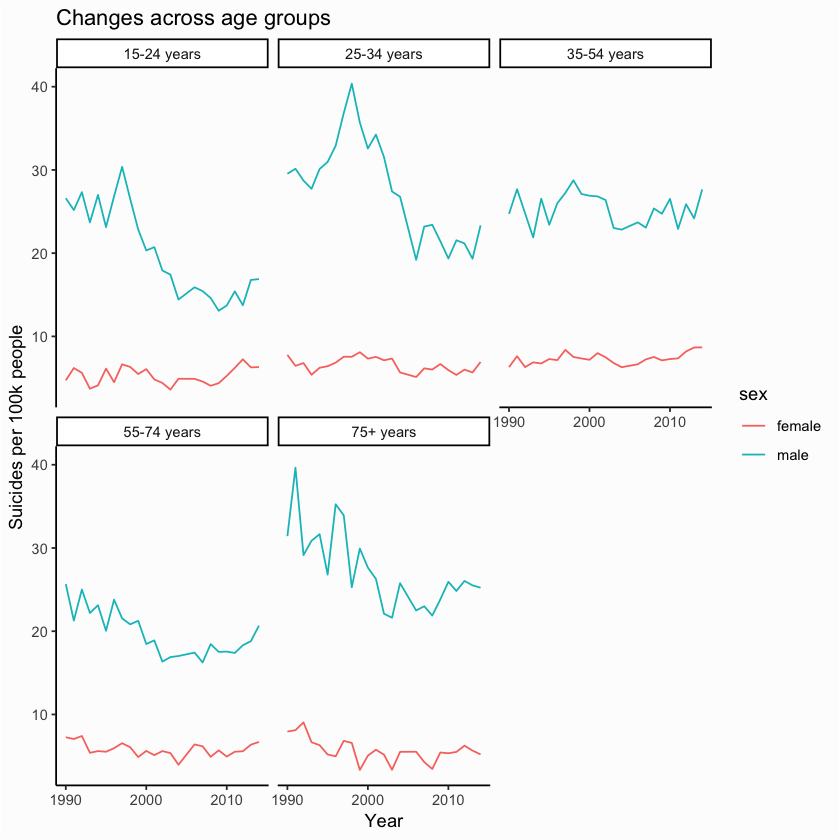

In [16]:
suicide_data %>%
    filter(country=='Australia') %>%
    ggplot(aes(x=year, y=`suicides/100k pop`, color=sex)) +
        geom_line() +
        facet_wrap(~ age) +
        scale_x_continuous(breaks=seq(1990,2010,10)) +
        xlab('Year') + ylab('Suicides per 100k people') +
        ggtitle('Changes across age groups')

ggsave('visuals/rate_over_time_ages.png')

What about changes in GDP per capita and changes in suicide rates? As a preview of the modelling section, we pick three high and low GDP countries and observe how they have evolved over time.

Saving 7 x 7 in image


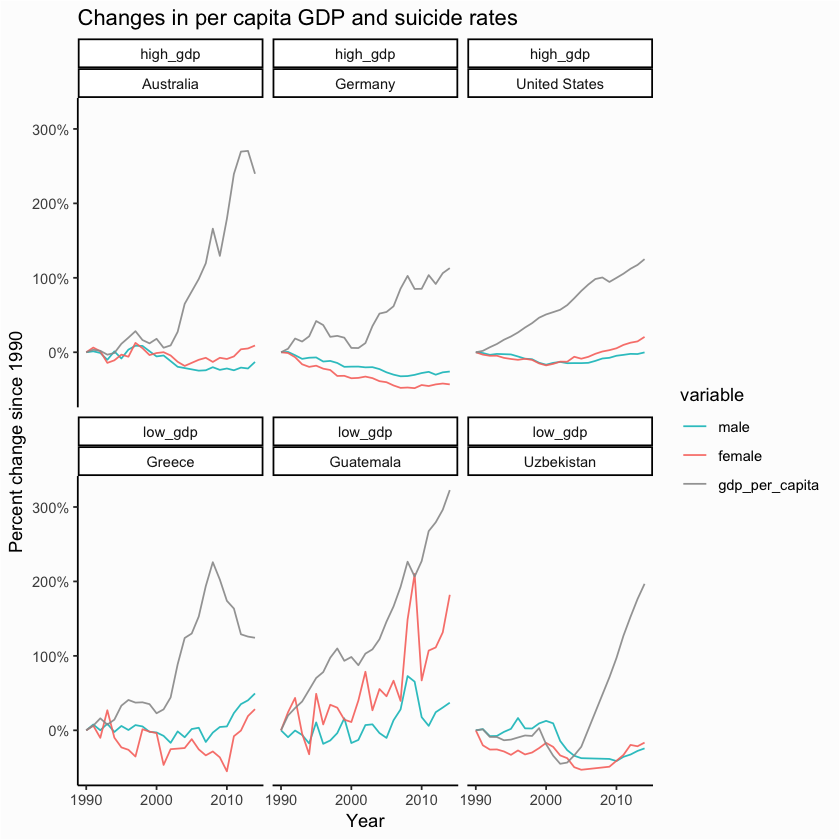

In [17]:
high_gdp <- c('Australia', 'Germany', 'United States')
low_gdp <- c('Guatemala', 'Uzbekistan', 'Greece')

suicide_data %>%
    filter(country %in% high_gdp | country %in% low_gdp) %>%
    group_by(country, year, sex) %>%
    summarise(suicide_rate=100000*sum(suicides_no)/sum(population), gdp_per_capita=first(`gdp_per_capita ($)`)) %>% 
    mutate(group=if_else(country %in% high_gdp, 'high_gdp', 'low_gdp')) %>%
    spread(sex, suicide_rate) %>%
    group_by(country) %>%
    arrange(country, year) %>%
    mutate(gdp_per_capita = (gdp_per_capita / first(gdp_per_capita)) - 1,
           female = (female / first(female)) - 1, 
           male = (male / first(male)) - 1) %>%
    gather(key='variable', value='value', gdp_per_capita, female, male) %>%
    mutate(variable=factor(variable, levels=c('male', 'female', 'gdp_per_capita'))) %>%
    ggplot(aes(x=year, y=value, color=variable, group=variable)) +
        geom_line(alpha=0.9) +
        facet_wrap(group ~ country) +
        scale_color_manual(values=c("#00BFC4", "#F8766D", "#999999")) +
        scale_y_continuous(labels=scales::percent_format()) +
        scale_x_continuous(breaks=seq(1990,2010,10)) +
        xlab('Year') + ylab('Percent change since 1990') +
        ggtitle('Changes in per capita GDP and suicide rates')
    
ggsave('visuals/gdp_and_suicide_rate.png')

Results are not clear: we need a model to better understand.

## Modelling
Finally, let's build a model for the suicide rate. This will allow us to answer our final question: what is the relationship between the suicide rate and per capita GDP? We will use a simple linear regression. The model specification is as follows:

$$ \log(\text{suicide rate}) = \beta_0 + \beta_1 \cdot \text{sex} + \beta_2 \cdot \text{age} + \beta_3 \cdot \log(\text{GDP per capita}) + \beta_4 \cdot \text{generation} + \beta_5 \cdot \log(\text{population}) + \beta_6 \cdot \text{year} + \beta_7 \cdot \text{sex} \cdot \log(\text{GDP per capita})$$

Log transformations are used to combat the skewness of the numeric variables, yielding distributions that are much close to normal. Care is however required in the interpretation of their estimated parameters. We also include an interaction variable to allow the effect of per capita GDP to differ between men and women.

In [18]:
model_data <- suicide_data %>%
    select(sex, age, per_capita_gdp=`gdp_per_capita ($)`, generation, 
           population=population, year, suicide_rate=`suicides/100k pop`) %>%
    filter(suicide_rate > 0.0001) %>%
    mutate(log_suicide_rate=log(suicide_rate), log_per_capita_gdp=log(per_capita_gdp),
           log_population=log(population))

model <- lm(log_suicide_rate ~ sex + age + log_per_capita_gdp + 
            generation + log_population + year + sex * log_per_capita_gdp,
            data = model_data)

summary(model)


Call:
lm(formula = log_suicide_rate ~ sex + age + log_per_capita_gdp + 
    generation + log_population + year + sex * log_per_capita_gdp, 
    data = model_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9070 -0.4630  0.0799  0.5550  2.6634 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                35.8009537  4.1428274   8.642  < 2e-16 ***
sexmale                     1.9432758  0.1323939  14.678  < 2e-16 ***
age25-34 years              0.2794368  0.0342825   8.151 4.07e-16 ***
age35-54 years              0.5458158  0.0538084  10.144  < 2e-16 ***
age55-74 years              0.6505373  0.0839825   7.746 1.05e-14 ***
age75+ years                0.9335020  0.0991988   9.410  < 2e-16 ***
log_per_capita_gdp          0.1393931  0.0104978  13.278  < 2e-16 ***
generationSilent           -0.0732774  0.0453366  -1.616  0.10606    
generationBoomers          -0.0504396  0.0775964  -0.650  0.51569    
generationGeneration X     

In [19]:
model_summary <- autoplot(model)

ggsave('visuals/model_results.png', plot=model_summary)

Saving 7 x 7 in image


We can now interpret this model.